# Bedrock AgentCore Memory Store Walkthrough - Long Term Memory w/ Retrieval Tools

This sample notebook walks through setup and usage of the Bedrock AgentCore Memory Store with LangGraph. This approach enables saving of conversations to the AgentCore memory API to be later extracted and retrieved, enabling long term memory.

### Setup
For this notebook you will need:
1. An Amazon Web Services development account
2. Bedrock Model Access (i.e. Claude 3.7 Sonnet)
3. An AgentCore Memory Resource configured (see below section for details)
4. Two strategies enabled for the Agent Core Memory resource, `/facts/{actor_id}` semantic search and `/preferences/{actor_id}` user preference search

### AgentCore Memory Resource

Either in the AWS developer portal or using the boto3 library you must create an [AgentCore Memory Resource](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/bedrock-agentcore-control/client/create_memory.html). For this notebook, only two strategies need to be enabled, user preferences and semantic memory. These strategies will automatically run once we save our conversational messages to AgentCore Memory and extract chunks of information that our agent can retrieve later. For more information on long term memory, see the docs here [AgentCore Long Term Memory](https://docs.aws.amazon.com/bedrock-agentcore/latest/devguide/long-term-memory.html).

Once you have the Memory enabled and in a `ACTIVE` state, take note of the `memoryId` and strategy namespaces, we will need them later.

In [ ]:
%pip install langchain langchain-aws

In [1]:
# Import LangGraph and LangChain components
from langchain.chat_models import init_chat_model
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.runnables import RunnableConfig
from langgraph.store.base import BaseStore
import uuid
import logging
logging.getLogger().setLevel(logging.DEBUG)

In [4]:
# Import the AgentCoreMemoryStore that we will use as a store
from langgraph_checkpoint_aws import (
    AgentCoreMemoryStore,
    create_store_event_tool,
    create_search_memory_tool
)

# For this example, we will just use an InMemorySaver to save context.
# In production, we highly recommend the AgentCoreMemorySaver as a checkpointer
# which works seamlessly alongside the memory store
from langgraph.checkpoint.memory import InMemorySaver

## AgentCore Memory Configuration
- `REGION` corresponds to the AWS region that your resources are present in, these are passed to the `AgentCoreMemorySaver`.
- `MEMORY_ID` corresponds to your top level AgentCore Memory resource. Within this resource we will store messages from multiple users and sessions
- `MODEL_ID` this is the bedrock model that will power our LangGraph agent.

We will use the `MEMORY_ID` and any additional boto3 client keyword args (in our case, `REGION`) to create the store.

In [17]:
REGION = "us-west-2"
MEMORY_ID = "memory_ghc4p-Hx6JcCEtH3"
MODEL_ID = "us.anthropic.claude-3-7-sonnet-20250219-v1:0"

# Initialize the store to enable long term memory saving and retrieval
store = AgentCoreMemoryStore(memory_id=MEMORY_ID, region_name=REGION)

# Initialize Bedrock LLM
llm = init_chat_model(MODEL_ID, model_provider="bedrock_converse", region_name=REGION)

### Storing the messages that we want for long term memory extraction

For this notebook, we will only be looking at tools to save and retrieve memories per the agents discretion using tools. More deterministic approaches involve using the pre/post model hooks.

For techniques on storing messages in pre/post model hooks rather than with agent tools, see this notebook: [https://github.com/langchain-ai/langchain-aws/blob/main/samples/memory/agentcore_memory_store_long_term_search.ipynb](https://github.com/langchain-ai/langchain-aws/blob/main/samples/memory/agentcore_memory_store_long_term_search.ipynb).

## Define our long term memory saving and retrieval tools
We will use a tool factory built for the AgentCore memory store so we can define tools for any namespace that we want to search over based on the strategies created for our memory resource. These tool factories take care of the logic under the hood for loading actor_id and thread_id from the runtime configuration, ensuring that a tool is only searching over the namespaces for that current user and session.

To accomplish this, similar to how AgentCore memory implements namespace placeholders for {actor_id} and {session_id}, we will also provide these to the tool factory so that it knows how to inject these arguments at runtime.

The tools will allow the agent to save messages that are important and search the namespace we specify, in this case the /facts/{actor_id} namespace which is a semantic memory namespace we specified above (at the top of the notebook). As the memories are extracted over time, these will be available to the agent through this tool.

In [10]:
# Create the memory save tool using the factory
# The actor ID and session ID are handled under the hood at runtime to save to the actor and session based on the invocation below
save_events_to_memory_tool = create_store_event_tool(
    name="save_events_to_memory",
)

# Create the memory search tool using the factory
retrieve_past_conversation_facts_tool = create_search_memory_tool(
    namespace=("facts", "{actor_id}"), # Placeholder for actor ID, specifying the namespace we defined /facts/{actorId} in AgentCore Memory
    instructions="Retrieve facts and user preferences about the user that might be helpful in answering vague questions",
    name="get_past_conversation_facts",
)

tools = [save_events_to_memory_tool, retrieve_past_conversation_facts_tool]

## Build our LangGraph agent graph

Our agent will be built with the `create_react_agent` builder. It just has a few simple nodes, mainly a chatbot node and a tool node. The tool node will contain just our long term memory retrieval tool and the pre and post model hooks are specified as arguments.

**Note**: for custom agent implementations the Store and tools can be configured to run as needed for any workflow following this pattern. Pre/post model hooks can be used, the whole conversation could be saved at the end, etc.

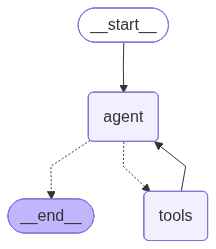

In [28]:
graph = create_react_agent(
    llm,
    store=store,
    tools=tools,
    checkpointer=InMemorySaver()
)

graph

## IMPORTANT: Input and Config

### Graph Invoke Input
We only need to pass the newest user message in as an argument `inputs`. This could include other state variables too but for the simple `create_react_agent`, messages are all that's required.

### LangGraph RuntimeConfig
In LangGraph, config is a `RuntimeConfig` that contains attributes that are necessary at invocation time, for example user IDs or session IDs. For the `AgentCoreMemorySaver`, `thread_id` and `actor_id` must be set in the config. For instance, your AgentCore invocation endpoint could assign this based on the identity or user ID of the caller. Additional documentation here: [https://langchain-ai.github.io/langgraphjs/how-tos/configuration/](https://langchain-ai.github.io/langgraphjs/how-tos/configuration/)



In [29]:
config = {
    "configurable": {
        "thread_id": "session-1", # REQUIRED: This maps to Bedrock AgentCore session_id under the hood
        "actor_id": "usr-1", # REQUIRED: This maps to Bedrock AgentCore actor_id under the hood
    }
}

### Run the Agent

For this example, we will run through a conversation where the user is talking about what they like to cook with. This will give the backend enough context to extract facts and user preferences that we can retrieve the next time the user asks for what to make on a given evening.

In [30]:
# Helper function to pretty print agent output while running
def run_agent(query: str, config: RunnableConfig):
    printed_ids = set()
    events = graph.stream(
        {"messages": [{"role": "user", "content": query}]},
        config,
        stream_mode="values",
    )
    for event in events:
        if "messages" in event:
            for msg in event["messages"]:
                # Check if we've already printed this message
                if id(msg) not in printed_ids:
                    msg.pretty_print()
                    printed_ids.add(id(msg))


prompt = """
Hey there! Im cooking one of my favorite meals tonight, salmon with rice and veggies (healthy). Has
great macros for my weightlifting competition that is coming up. What can I add to this dish to make it taste better
and also improve the protein and vitamins I get?

Make sure to make note of this for future competitions.
"""

run_agent(prompt, config)

================================ Human Message =================================


Hey there! Im cooking one of my favorite meals tonight, salmon with rice and veggies (healthy). Has
great macros for my weightlifting competition that is coming up. What can I add to this dish to make it taste better
and also improve the protein and vitamins I get?

Make sure to make note of this for future competitions.



Skipping unsupported message type: text
No valid event messages to create for message type: text


================================== Ai Message ==================================

[{'type': 'text', 'text': "I'd be happy to suggest some additions to your salmon dish that could enhance both flavor and nutritional content, especially for your weightlifting competition prep. Let me help with ideas that boost protein and vitamins.\n\nFor your salmon, rice, and veggie meal, you could consider:\n\n1. **Protein boosters:**\n   - Add Greek yogurt as a creamy sauce base (high protein, low fat)\n   - Mix in some edamame with your rice (complete protein)\n   - Sprinkle hemp seeds or chopped nuts for texture and protein\n   - Include quinoa mixed with your rice (complete protein grain)\n\n2. **Flavor enhancers:**\n   - Fresh herbs like dill, cilantro or parsley \n   - Lemon zest or a squeeze of citrus\n   - Low-sodium soy sauce or coconut aminos\n   - Garlic and ginger (also have anti-inflammatory properties)\n\n3. **Vitamin/mineral boosters:**\n   - Add leafy greens like spinach or kale (iron,

### Agent access to the store

**Note** - since AgentCore memory processes these events in the background, it may take a few seconds for the memory to be extracted and embedded to long term memory retrieval.

Great! Now we have seen that long term memories were extracted to our namespaces based on the earlier messages in the conversation.

Now, let's start a new session and ask about recommendations for what to cook for dinner. The agent can use the store to access the long term memories that were extracted to make a recommendation that the user will be sure to like.

In [39]:
config = {
    "configurable": {
        "thread_id": "session-2", # New session ID
        "actor_id": "usr-1", # Same actor ID
    }
}

run_agent("Today's a new day, what should I make for dinner tonight?", config)

================================ Human Message =================================

Today's a new day, what should I make for dinner tonight?
================================== Ai Message ==================================

[{'type': 'text', 'text': "I'd be happy to help you with dinner ideas for tonight. Since this is a new day and I don't have information about your food preferences or dietary restrictions, I should gather some relevant past information first.\n\nLet me search for any previous conversations about food preferences you may have shared:"}, {'type': 'tool_use', 'name': 'get_past_conversation_facts', 'input': {'query': 'food preferences dinner recipes ingredients dietary restrictions cooking'}, 'id': 'tooluse_Ph2_kBOvRKq9X0lahSmLxw'}]
Tool Calls:
  get_past_conversation_facts (tooluse_Ph2_kBOvRKq9X0lahSmLxw)
 Call ID: tooluse_Ph2_kBOvRKq9X0lahSmLxw
  Args:
    query: food preferences dinner recipes ingredients dietary restrictions cooking
================================= T

### Wrapping up

The tool approach is not as deterministic as the pre/post model hook approach, but does give the agent more say in what memories to store and query for during a coversation.

Used alongside the AgentCoreMemorySaver for checkpointing, both full conversational state and long term insights can be combined to form a complex and intelligent agent system.